In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='./resources')
nltk.download('punkt', download_dir='./resources')
nltk.download('wordnet', download_dir='./resources')
nltk.download('omw-1.4', download_dir='./resources')
nltk.download('words', download_dir='./resources')
nltk.data.path.append('./resources')

[nltk_data] Downloading package stopwords to ./resources...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./resources...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./resources...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./resources...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to ./resources...
[nltk_data]   Package words is already up-to-date!


## Trends limits:
By default, it is set to 100 requests per 100 seconds per user and can be adjusted to a maximum value of 1,000. But the number of requests to the API is restricted to a maximum of 10 requests per second per user.

In [2]:
!ls && ls ./Data

Data                        infer_results.ipynb
assets                      resources
combined_analysis.ipynb     titles_analysis.ipynb
descriptions_analysis.ipynb
bbc_news.csv                          kmeans-clusters.csv
clusters.csv                          title-agg-complete-clusters.csv
description-agg-complete-clusters.csv title-agg-ward-clusters.csv
description-agg-ward-clusters.csv     title-dbscan-clusters.csv
description-dbscan-clusters.csv       title-kmeans-clusters.csv
description-kmeans-clusters.csv       title-optics-clusters.csv
description-optics-clusters.csv       topics_short.csv


### Configs...

In [3]:
TRENDS = True

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('Data/bbc_news.csv')
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                            pubDate  \
0     Mon, 07 Mar 2022 08:01:56 GMT   
1     Sun, 06 Mar 2022 22:49:58 GMT   
2     Mon, 07 Mar 2022 00:14:42 GMT   
3     Mon, 07 Mar 2022 00:05:40 GMT   
4     Mon, 07 Mar 2022 08:15:53 GMT   
...                             ...   
8116  Sat, 17 Sep 2022 22:54:46 GMT   
8117  Sat, 17 Sep 2022 06:25:17 GMT   
8118  Fri, 16 Sep 2022 23:01:06 GMT   
8119  Fri, 16 Sep 2022 14:52:59 GMT   
8120  Sat, 17 Sep 2022 06:38:22 GMT   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8121 non-null   object
 1   pubDate      8121 non-null   object
 2   guid         8121 non-null   object
 3   link         8121 non-null   object
 4   description  8121 non-null   object
dtypes: object(5)
memory usage: 317.4+ KB


In [6]:
data.describe()

title  \
count                                                8121   
unique                                               7746   
top     Ukraine war in maps: Tracking the Russian inva...   
freq                                                   32   

                              pubDate  \
count                            8121   
unique                           7981   
top     Fri, 15 Jul 2022 15:23:03 GMT   
freq                                3   

                                                    guid  \
count                                               8121   
unique                                              7432   
top     https://www.bbc.co.uk/news/world-europe-60506682   
freq                                                  40   

                                                     link  \
count                                                8121   
unique                                               7432   
top     https://www.bbc.co.uk/news/world-europe-605066...   
freq                                                   40   

                                              description  
count                                                8121  
unique                                               7645  
top     How closely have you been paying attention to ...  
freq                                                   23

In [7]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
8116 2022-09-17 22:54:46+00:00   
8117 2022-09-17 06:25:17+00:00   
8118 2022-09-16 23:01:06+00:00   
8119 2022-09-16 14:52:59+00:00   
8120 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

## Remove duplicates

In [8]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
7359  Saracens battle back from 17-0 down to beat Ha...  
7360  Thousands of people have lined up for miles to...  
7361  Sitting with the heads of state at Monday's fu...  
7362  When the monarch visited a US housing project ...  
7363  The Queen's association with Windsor Great Par...  

[7364 rows x 5 columns]

In [9]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [10]:
sns.set_style('darkgrid')

In [11]:
data['combined'] = data['title'] + ' ' + data['description']
data['combined']

0       Ukraine: Angry Zelensky vows to punish Russian...
1       War in Ukraine: Taking cover in a town under a...
2       Ukraine war 'catastrophic for global food' One...
3       Manchester Arena bombing: Saffie Roussos's par...
4       Ukraine conflict: Oil price soars to highest l...
                              ...                        
7359    Premiership: Harlequins 27-30 Saracens - Sarri...
7360    The queue - and the expert who helped plan it ...
7361    The cowboy and the Queen who bonded over horse...
7362    Queen amused by an American's breach of protoc...
7363    Queen Elizabeth II's special connection with W...
Name: combined, Length: 7364, dtype: object

In [12]:
top_N = 50
a = data['combined'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

Word  Frequency
0           says       1117
1        ukraine       1046
2        england        714
3            war        678
4            new        616
5          first        542
6             uk        537
7           2022        490
8          world        455
9            win        448
10            us        433
11        people        422
12       russian        406
13        league        384
14           say        371
15           bbc        352
16           one        344
17         years        342
18          city        333
19        russia        322
20         final        320
21           day        314
22         could        299
23           two        290
24        papers        277
25    manchester        266
26          open        264
27           cup        250
28           man        248
29         queen        235
30        police        231
31         watch        225
32          back        221
33        womens        221
34         games        221
35          euro        215
36          home        211
37        energy        206
38  commonwealth        205
39     ukrainian        199
40          time        196
41         covid        193
42          help        190
43     liverpool        190
44             v        185
45         boris        182
46    government        179
47            pm        178
48        former        176
49         three        175

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'says'),
  Text(1, 0, 'ukraine'),
  Text(2, 0, 'england'),
  Text(3, 0, 'war'),
  Text(4, 0, 'new'),
  Text(5, 0, 'first'),
  Text(6, 0, 'uk'),
  Text(7, 0, '2022'),
  Text(8, 0, 'world'),
  Text(9, 0, 'win'),
  Text(10, 0, 'us'),
  Text(11, 0, 'people'),
  Text(12, 0, 'russian'),
  Text(13, 0, 'league'),
  Text(14, 0, 'say'),
  Text(15, 0, 'bbc'),
  Text(16, 0, 'one'),
  Text(17, 0, 'years'),
  Text(18, 0, 'city'),
  Text(19, 0, 'russia'),
  Text(20, 0, 'final'),
  Text(21, 0, 'day'),
  Text(22, 0, 'could'),
  Text(23, 0, 'two'),
  Text(24, 0, 'papers'),
  Text(25, 0, 'manchester'),
  Text(26, 0, 'open'),
  Text(27, 0, 'cup'),
  Text(28, 0, 'man'),
  Text(29, 0, 'queen'),
  Text(30, 0, 'police'),
  Text(31, 0, 'watch'),
  Text(32, 0, 'back'),
  Text(

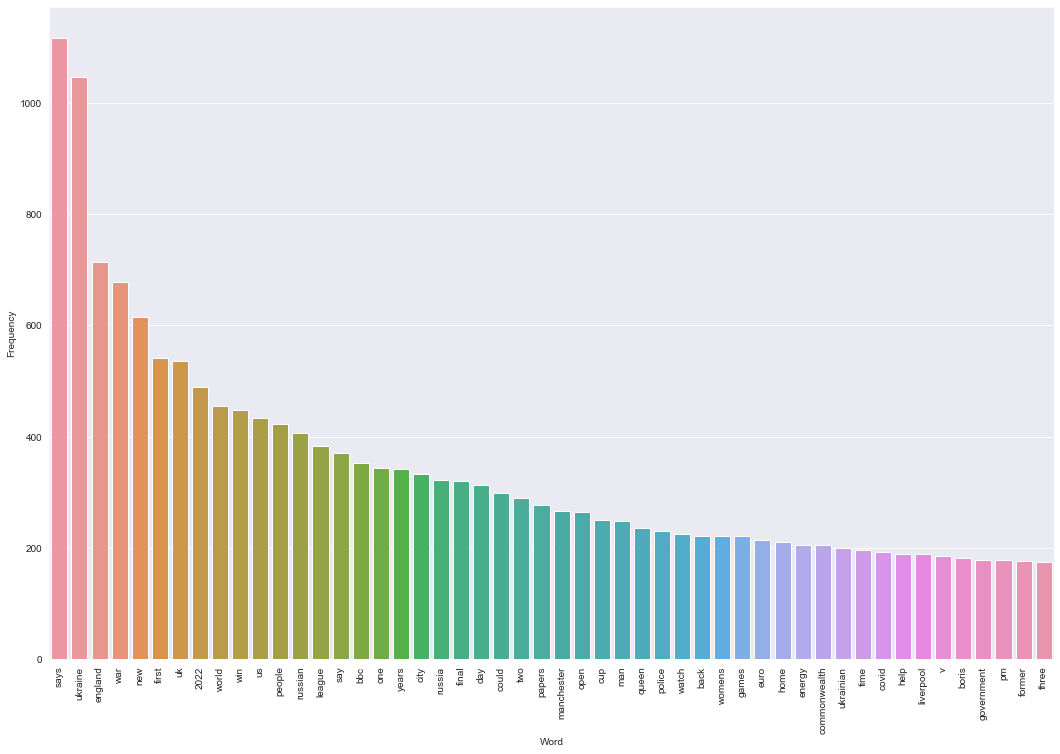

In [13]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [14]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [15]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukraine', 'angry'),
 ('angry', 'zelensky'),
 ('zelensky', 'vows'),
 ('vows', 'punish'),
 ('punish', 'russian'),
 ('russian', 'atrocities'),
 ('atrocities', 'ukrainian'),
 ('ukrainian', 'president'),
 ('president', 'says'),
 ('says', 'country'),
 ('country', 'forgive'),
 ('forgive', 'forget'),
 ('forget', 'murder'),
 ('murder', 'civilians'),
 ('civilians', 'war'),
 ('war', 'ukraine'),
 ('ukraine', 'taking'),
 ('taking', 'cover'),
 ('cover', 'town'),
 ('town', 'attack'),
 ('attack', 'jeremy'),
 ('jeremy', 'bowen'),
 ('bowen', 'frontline'),
 ('frontline', 'irpin'),
 ('irpin', 'residents'),
 ('residents', 'came'),
 ('came', 'russian'),
 ('russian', 'fire'),
 ('fire', 'trying'),
 ('trying', 'flee'),
 ('flee', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'catastrophic'),
 ('catastrophic', 'global'),
 ('global', 'food'),
 ('food', 'one'),
 ('one', 'worlds'),
 ('worlds', 'biggest'),
 ('biggest', 'fertiliser'),
 ('fertiliser', 'firms'),
 ('firms', 'says'),
 ('says', 'conflict'),
 ('conflict', '

In [16]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

N-gram  Frequency
0              (ukraine, war)        358
1                (euro, 2022)        206
2       (commonwealth, games)        170
3                (world, cup)        151
4            (boris, johnson)        143
5           (premier, league)        128
6         (champions, league)        120
7              (cost, living)        116
8             (south, africa)        110
9          (manchester, city)        109
10             (war, ukraine)         99
11               (england, v)         96
12               (liz, truss)         95
13       (manchester, united)         90
14         (queen, elizabeth)         76
15             (new, zealand)         75
16                 (us, open)         74
17              (first, time)         72
18          (prime, minister)         72
19         (tory, leadership)         68
20        (northern, ireland)         65
21            (elizabeth, ii)         63
22             (rishi, sunak)         62
23        (platinum, jubilee)         62
24           (emma, raducanu)         60
25              (grand, prix)         59
26            (social, media)         58
27         (ukraine, roundup)         57
28             (front, pages)         52
29             (real, madrid)         52
30             (french, open)         52
31               (bbc, sport)         51
32          (climate, change)         51
33                (new, york)         47
34            (energy, bills)         47
35              (police, say)         46
36                  (fa, cup)         45
37             (andy, murray)         42
38             (lead, papers)         42
39                (man, city)         41
40                (west, ham)         41
41              (ben, stokes)         40
42            (league, final)         40
43            (womens, world)         38
44  (european, championships)         37
45                 (v, south)         37
46               (tells, bbc)         36
47            (king, charles)         36
48             (six, nations)         35
49              (ros, atkins)         34

In [17]:
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('ukraine', 'war')"),
  Text(1, 0, "('euro', '2022')"),
  Text(2, 0, "('commonwealth', 'games')"),
  Text(3, 0, "('world', 'cup')"),
  Text(4, 0, "('boris', 'johnson')"),
  Text(5, 0, "('premier', 'league')"),
  Text(6, 0, "('champions', 'league')"),
  Text(7, 0, "('cost', 'living')"),
  Text(8, 0, "('south', 'africa')"),
  Text(9, 0, "('manchester', 'city')"),
  Text(10, 0, "('war', 'ukraine')"),
  Text(11, 0, "('england', 'v')"),
  Text(12, 0, "('liz', 'truss')"),
  Text(13, 0, "('manchester', 'united')"),
  Text(14, 0, "('queen', 'elizabeth')"),
  Text(15, 0, "('new', 'zealand')"),
  Text(16, 0, "('us', 'open')"),
  Text(17, 0, "('first', 'time')"),
  Text(18, 0, "('prime', 'minister')"),
  Text(19, 0, "('tory', 'leadership')"),
  Text(20, 0, "('n

In [18]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukraine', 'angry', 'zelensky'),
 ('angry', 'zelensky', 'vows'),
 ('zelensky', 'vows', 'punish'),
 ('vows', 'punish', 'russian'),
 ('punish', 'russian', 'atrocities'),
 ('russian', 'atrocities', 'ukrainian'),
 ('atrocities', 'ukrainian', 'president'),
 ('ukrainian', 'president', 'says'),
 ('president', 'says', 'country'),
 ('says', 'country', 'forgive'),
 ('country', 'forgive', 'forget'),
 ('forgive', 'forget', 'murder'),
 ('forget', 'murder', 'civilians'),
 ('murder', 'civilians', 'war'),
 ('civilians', 'war', 'ukraine'),
 ('war', 'ukraine', 'taking'),
 ('ukraine', 'taking', 'cover'),
 ('taking', 'cover', 'town'),
 ('cover', 'town', 'attack'),
 ('town', 'attack', 'jeremy'),
 ('attack', 'jeremy', 'bowen'),
 ('jeremy', 'bowen', 'frontline'),
 ('bowen', 'frontline', 'irpin'),
 ('frontline', 'irpin', 'residents'),
 ('irpin', 'residents', 'came'),
 ('residents', 'came', 'russian'),
 ('came', 'russian', 'fire'),
 ('russian', 'fire', 'trying'),
 ('fire', 'trying', 'flee'),
 ('trying', 'fle

In [19]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

N-gram  Frequency
0              (queen, elizabeth, ii)         61
1                (womens, world, cup)         37
2                  (v, south, africa)         37
3                 (england, v, south)         36
4                   (england, v, new)         29
5                   (v, new, zealand)         29
6          (champions, league, final)         28
7              (cost, living, crisis)         27
8      (world, snooker, championship)         26
9   (commonwealth, games, birmingham)         25
10                     (roe, v, wade)         24
11        (2022, commonwealth, games)         22
12                (euro, 2022, final)         22
13                (england, v, india)         21
14               (king, charles, iii)         19
15             (ukraine, war, russia)         18
16        (commonwealth, games, 2022)         18
17               (world, number, one)         17
18                   (fa, cup, final)         17
19              (euro, 2022, england)         17
20            (ukraine, war, russian)         16
21             (womens, six, nations)         16
22                   (erik, ten, hag)         16
23                 (tour, de, france)         16
24  (world, athletics, championships)         16
25  (european, championships, munich)         16
26              (world, cup, playoff)         14
27               (come, behind, beat)         14
28      (snooker, championship, 2022)         14
29          (election, results, 2022)         14
30            (us, pga, championship)         14
31               (fa, cup, semifinal)         13
32               (first, time, since)         13
33               (energy, price, cap)         13
34           (premier, league, title)         13
35   (european, womens, championship)         13
36  (birmingham, commonwealth, games)         13
37          (death, queen, elizabeth)         13
38             (top, premier, league)         12
39               (watch, best, shots)         12
40      (northern, ireland, protocol)         12
41               (test, new, zealand)         12
42                (rishi, sunak, liz)         12
43                (sunak, liz, truss)         12
44                 (world, cup, 2022)         11
45                    (match, day, 2)         11
46    (highlights, watch, highlights)         11
47               (ni, election, 2022)         11
48             (british, number, one)         11
49              (jurgen, klopp, says)         11

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('queen', 'elizabeth', 'ii')"),
  Text(1, 0, "('womens', 'world', 'cup')"),
  Text(2, 0, "('v', 'south', 'africa')"),
  Text(3, 0, "('england', 'v', 'south')"),
  Text(4, 0, "('england', 'v', 'new')"),
  Text(5, 0, "('v', 'new', 'zealand')"),
  Text(6, 0, "('champions', 'league', 'final')"),
  Text(7, 0, "('cost', 'living', 'crisis')"),
  Text(8, 0, "('world', 'snooker', 'championship')"),
  Text(9, 0, "('commonwealth', 'games', 'birmingham')"),
  Text(10, 0, "('roe', 'v', 'wade')"),
  Text(11, 0, "('2022', 'commonwealth', 'games')"),
  Text(12, 0, "('euro', '2022', 'final')"),
  Text(13, 0, "('england', 'v', 'india')"),
  Text(14, 0, "('king', 'charles', 'iii')"),
  Text(15, 0, "('ukraine', 'war', 'russia')"),
  Text(16, 0, "('commonwealth', 'games'

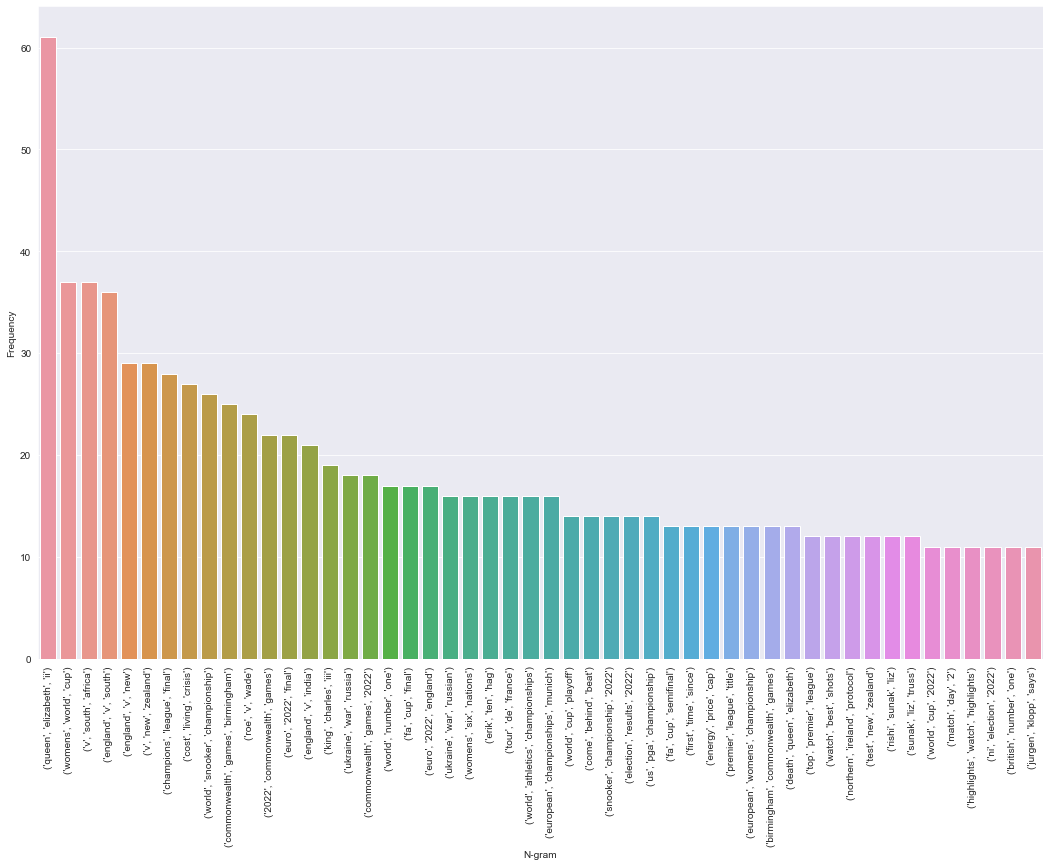

In [20]:
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Cleaning data (removing punctuation)

In [24]:
# lower and remove punctuation
data['combined_cleaned'] = data['combined'].str.lower().apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  
0     ukraine angry zelensky vows to p

In [25]:
# remove redundant spaces
data['combined_cleaned'] = data['combined_cleaned'].str.strip()
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  
0     ukraine angry zelensky vows to p

In [26]:
data['combined_cleaned'][0], data['combined_cleaned'][1]

('ukraine angry zelensky vows to punish russian atrocities the ukrainian president says the country will not forgive or forget those who murder its civilians',
 'war in ukraine taking cover in a town under attack jeremy bowen was on the frontline in irpin as residents came under russian fire while trying to flee')

In [27]:
data['combined_cleaned'].apply(len).describe()

count    7364.000000
mean      163.937806
std        29.922657
min        70.000000
25%       146.000000
50%       156.000000
75%       172.000000
max       321.000000
Name: combined_cleaned, dtype: float64

# Lemmatization

In [28]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [29]:
data['combined_cleaned']=data['combined_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['combined'][100], data['combined_cleaned'][100]

('Cost of living: Warning UK faces biggest income squeeze in nearly 50 years The war in Ukraine will lead to an even tighter squeeze on living standards this spring, a think tank says.',
 'cost living warning uk face biggest income squeeze nearly 50 year war ukraine lead even tighter squeeze living standard spring think tank say')

## Normalizing data

In [30]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['combined_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names_out())
dtm_data.index = data.index
dtm_data.head(5)

00  007  008  01  0100  02  03  03mm  04  05  ...  zookeepers  zoom  zsl  \
0   0    0    0   0     0   0   0     0   0   0  ...           0     0    0   
1   0    0    0   0     0   0   0     0   0   0  ...           0     0    0   
2   0    0    0   0     0   0   0     0   0   0  ...           0     0    0   
3   0    0    0   0     0   0   0     0   0   0  ...           0     0    0   
4   0    0    0   0     0   0   0     0   0   0  ...           0     0    0   

   zuckerberg  zulu  zurich  zuu  zverev  zwelithini  úsuga  
0           0     0       0    0       0           0      0  
1           0     0       0    0       0           0      0  
2           0     0       0    0       0           0      0  
3           0     0       0    0       0           0      0  
4           0     0       0    0       0           0      0  

[5 rows x 16277 columns]

# Wordclouds

In [31]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='black', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [32]:
ASSETS_PATH = './assets'

In [33]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [34]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

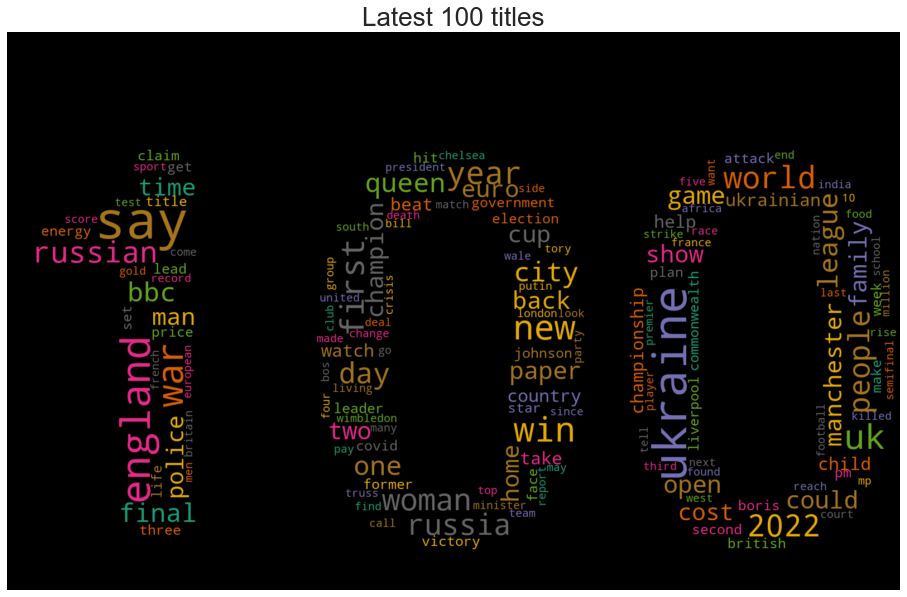

In [35]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [36]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [37]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

In [38]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [39]:
data['combined_polarity']=data['combined_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  
0     ukraine angry

In [40]:
data.describe()

combined_polarity
count        7364.000000
mean            0.054711
std             0.239993
min            -1.000000
25%            -0.013571
50%             0.000000
75%             0.160000
max             1.000000

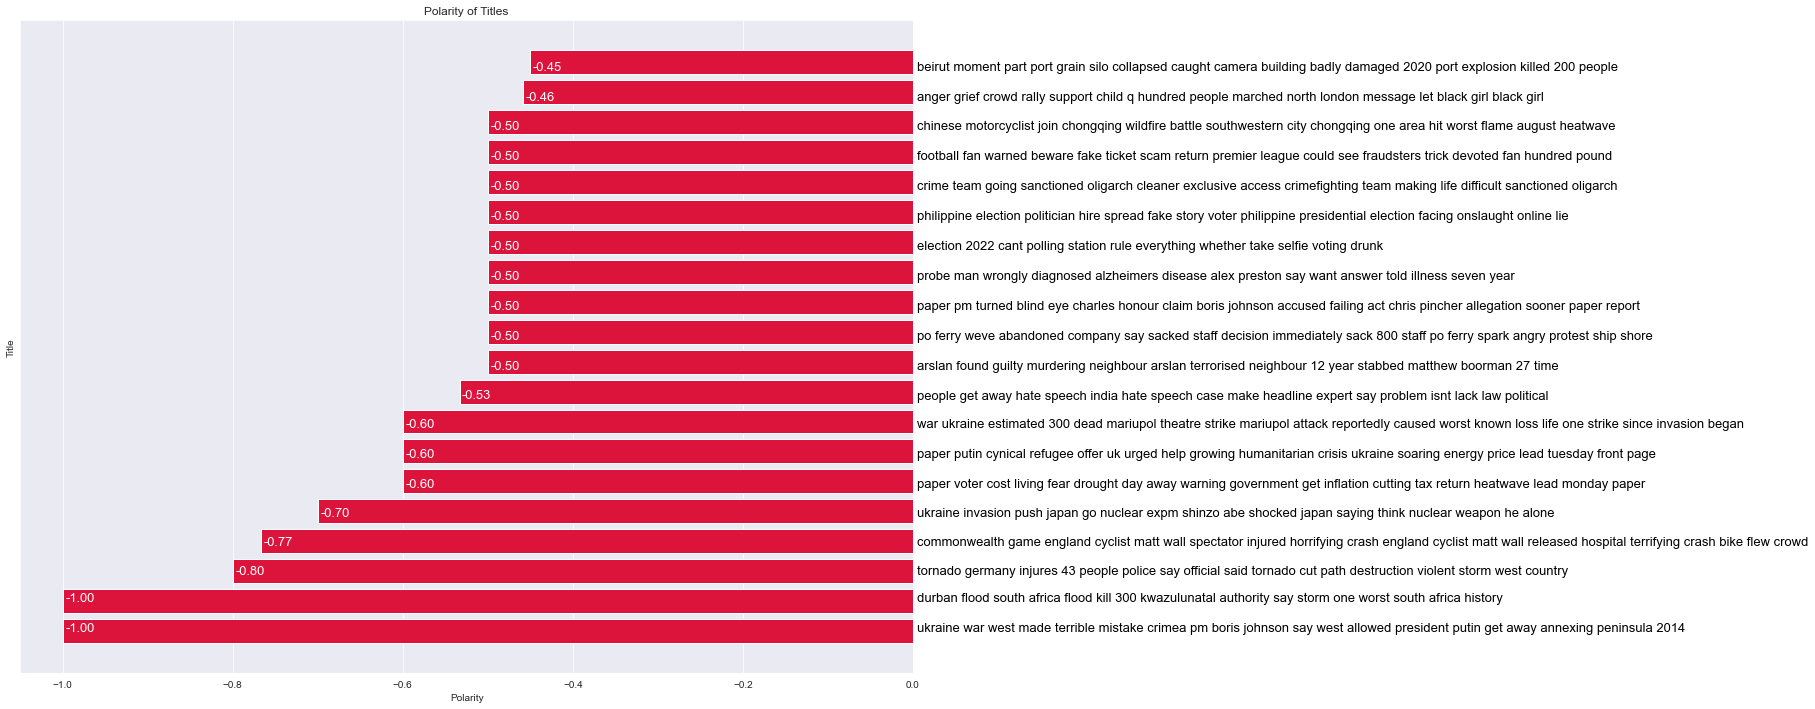

In [48]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['combined_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [42]:
title_polarity_sorted

369    -1.000000
1548   -1.000000
2933   -0.800000
5578   -0.766667
839    -0.700000
5881   -0.600000
110    -0.600000
773    -0.600000
1576   -0.533333
1203   -0.500000
520    -0.500000
4477   -0.500000
2726   -0.500000
2307   -0.500000
2420   -0.500000
3133   -0.500000
5670   -0.500000
6909   -0.500000
627    -0.458333
5587   -0.450000
Name: combined_polarity, dtype: float64

In [43]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

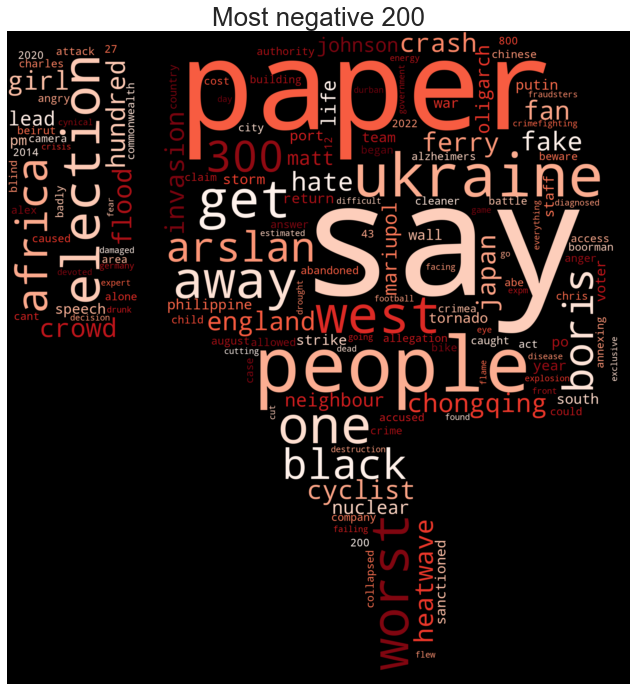

In [44]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

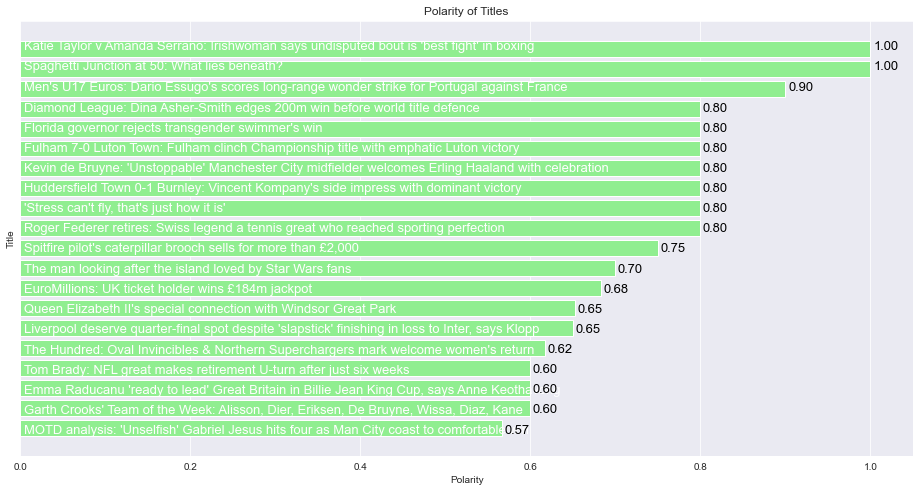

In [50]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['title'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [51]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

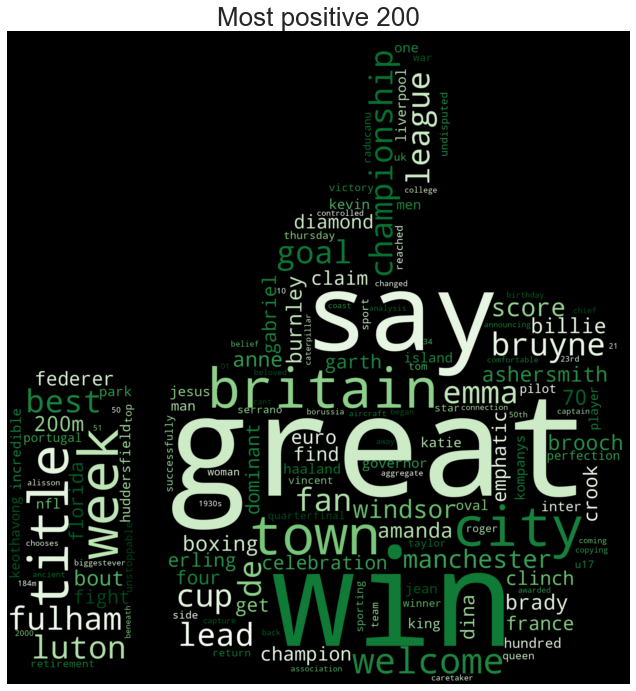

In [52]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)

# Lemmatization and filtering

In [53]:
word_freq_data_normalized = dtm_data.T
word_freq_data_normalized

0     1     2     3     4     5     6     7     8     9     ...  \
00             0     0     0     0     0     0     0     0     0     0  ...   
007            0     0     0     0     0     0     0     0     0     0  ...   
008            0     0     0     0     0     0     0     0     0     0  ...   
01             0     0     0     0     0     0     0     0     0     0  ...   
0100           0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
zurich         0     0     0     0     0     0     0     0     0     0  ...   
zuu            0     0     0     0     0     0     0     0     0     0  ...   
zverev         0     0     0     0     0     0     0     0     0     0  ...   
zwelithini     0     0     0     0     0     0     0     0     0     0  ...   
úsuga          0     0     0     0     0     0     0     0     0     0  ...   

            7354  7355  7356  7357  7358  7359  7360  7361  7362  7363  
00             0     0     0     0     0     0     0     0     0     0  
007            0     0     0     0     0     0     0     0     0     0  
008            0     0     0     0     0     0     0     0     0     0  
01             0     0     0     0     0     0     0     0     0     0  
0100           0     0     0     0     0     0     0     0     0     0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
zurich         0     0     0     0     0     0     0     0     0     0  
zuu            0     0     0     0     0     0     0     0     0     0  
zverev         0     0     0     0     0     0     0     0     0     0  
zwelithini     0     0     0     0     0     0     0     0     0     0  
úsuga          0     0     0     0     0     0     0     0     0     0  

[16277 rows x 7364 columns]

In [54]:
word_freq_data = pd.DataFrame(word_freq_data_normalized.sum(axis=1).reset_index()).rename(columns={'index': 'word', 0: 'freq'})
word_freq_data

word  freq
0              00     7
1             007     1
2             008     1
3              01    17
4            0100     1
...           ...   ...
16272      zurich     5
16273         zuu     2
16274      zverev     4
16275  zwelithini     2
16276       úsuga     1

[16277 rows x 2 columns]

In [55]:
nltk_lems = [lemmatizer.lemmatize(word) for word in nltk_words.words()] #stem the #words in the NLTK corpus so that they’re equivalent to the words in #the dataframe
df_nltk_words = pd.DataFrame() # make a new dataframe with the stemmed #NLTK words
df_nltk_words['word'] = nltk_lems
word_freq_data = word_freq_data[word_freq_data['word'].isin(df_nltk_words['word'])] #keep only #those in the stemmed NLTK corpus
word_freq_data

word  freq
723      abandon     1
724    abandoned    12
727        abbey     9
735      abdomen     1
736    abdominal     6
...          ...   ...
16256       zinc     1
16263     zombie     1
16265       zone    13
16266        zoo    15
16268       zoom     3

[8101 rows x 2 columns]

In [56]:
TRIM_QUANTILE = 0.7
word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(TRIM_QUANTILE)]

word  freq
724    abandoned    12
727        abbey     9
736    abdominal     6
752      ability     7
754         able    23
...          ...   ...
16209      youth     7
16223        zak     7
16242       zero     8
16265       zone    13
16266        zoo    15

[2681 rows x 2 columns]

# TFiDF Vectorization

In [57]:
stopwords = list(word_freq_data[word_freq_data['freq'] < word_freq_data['freq'].quantile(TRIM_QUANTILE)]['word'])
vec_vocab = list(word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(TRIM_QUANTILE)]['word'])

In [58]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords, vocabulary=vec_vocab)
tfidf_vectorizer

TfidfVectorizer(stop_words=['abandon', 'abdomen', 'abduct', 'abduction', 'abey',
                            'ablaze', 'aboard', 'aboriginal', 'absentee',
                            'absolute', 'absolutely', 'absorbing', 'abstain',
                            'absurd', 'abu', 'abundant', 'abuser', 'abusive',
                            'academic', 'acapulco', 'accelerated', 'accept',
                            'acceptable', 'acceptance', 'accessible',
                            'accession', 'accidental', 'accidentally',
                            'accommodation', 'accordion', ...],
                vocabulary=['abandoned', 'abbey', 'abdominal', 'ability',
                            'able', 'abortion', 'abroad', 'absence', 'abuse',
                            'academy', 'accepted', 'access', 'accident',
                            'according', 'account', 'accuse', 'accused',
                            'across', 'act', 'acting', 'action', 'activist',
                            'activity', 'actor', 'actress', 'ad', 'add',
                            'added', 'addiction', 'address', ...])

In [60]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_cleaned'])
tfidf_matrix

<7364x2681 sparse matrix of type '<class 'numpy.float64'>'
	with 74176 stored elements in Compressed Sparse Row format>

In [61]:
tfidf_data = pd.DataFrame(tfidf_matrix.toarray())
tfidf_data

0     1     2     3     4     5     6     7     8     9     ...  2671  \
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7359   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7360   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7361   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7362   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7363   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      2672  2673  2674  2675  2676  2677  2678  2679  2680  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
7359   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7360   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7361   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7362   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7363   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[7364 rows x 2681 columns]

In [62]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['abandoned', 'abbey', 'abdominal', ..., 'zero', 'zone', 'zoo'],
      dtype=object)

In [63]:
tfidf_data.columns = feature_names
tfidf_data

abandoned  abbey  abdominal  ability  able  abortion  abroad  absence  \
0           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
1           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
2           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
3           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
4           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
...         ...    ...        ...      ...   ...       ...     ...      ...   
7359        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7360        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7361        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7362        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7363        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   

      abuse  academy  ...  year  yet  york  young  younger  youth  zak  zero  \
0       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
1       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
2       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
3       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
4       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
...     ...      ...  ...   ...  ...   ...    ...      ...    ...  ...   ...   
7359    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7360    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7361    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7362    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7363    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   

      zone  zoo  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  
...    ...  ...  
7359   0.0  0.0  
7360   0.0  0.0  
7361   0.0  0.0  
7362   0.0  0.0  
7363   0.0  0.0  

[7364 rows x 2681 columns]

# TruncatedSVD

### during the experiments following configurations were tried:

* 1000 components - 10 clusters

* 100 components - 10 clusters

* 50 components - 10 clusters

* 100 components - 5 clusters

* 100 components - 15 clusters

In [64]:
tsvd = TruncatedSVD(n_components=100, random_state=37)
vec_matrix_tsvd = tsvd.fit_transform(tfidf_matrix)
vec_matrix_tsvd

array([[ 0.10629519, -0.0851171 , -0.02579576, ...,  0.05460128,
         0.02471475,  0.06180526],
       [ 0.0982134 , -0.10862729, -0.13019816, ...,  0.01159261,
        -0.02689949, -0.03367071],
       [ 0.19567946, -0.09988035, -0.07713626, ...,  0.01245465,
         0.00598126,  0.0437529 ],
       ...,
       [ 0.05161064, -0.01319609,  0.09743431, ..., -0.00699098,
        -0.03341598, -0.02247516],
       [ 0.03975166, -0.00923795,  0.08102742, ...,  0.01653657,
         0.00982462,  0.00792469],
       [ 0.07543361,  0.01024859,  0.10682045, ...,  0.00040642,
         0.05098183,  0.02915456]])

In [65]:
pd.DataFrame(vec_matrix_tsvd)

0         1         2         3         4         5         6   \
0     0.106295 -0.085117 -0.025796 -0.027154  0.006294  0.002043 -0.057865   
1     0.098213 -0.108627 -0.130198  0.053774  0.002393  0.018245  0.030913   
2     0.195679 -0.099880 -0.077136 -0.075899  0.115100  0.112440  0.026516   
3     0.045762 -0.026122 -0.004441  0.011500  0.024054  0.001964 -0.032896   
4     0.092458 -0.097637  0.122468 -0.110363 -0.068358  0.088930  0.040914   
...        ...       ...       ...       ...       ...       ...       ...   
7359  0.092755  0.105886 -0.023076  0.006783 -0.050479 -0.011604  0.018029   
7360  0.098017 -0.062053  0.134866  0.185576  0.113811 -0.042457 -0.035505   
7361  0.051611 -0.013196  0.097434  0.221123  0.111136 -0.059969 -0.011792   
7362  0.039752 -0.009238  0.081027  0.160061  0.087119 -0.042006 -0.010900   
7363  0.075434  0.010249  0.106820  0.245912  0.139241 -0.047986 -0.016580   

            7         8         9   ...        90        91        92  \
0    -0.004539 -0.078886 -0.008853  ... -0.026094 -0.010348 -0.024256   
1    -0.000542  0.045366 -0.009778  ...  0.034300  0.029965 -0.010517   
2    -0.034337  0.010862  0.098081  ...  0.006581 -0.014187 -0.044342   
3     0.017298  0.040273 -0.022330  ...  0.007008  0.055648  0.002737   
4    -0.075318  0.177967  0.202810  ... -0.030066 -0.002933 -0.001100   
...        ...       ...       ...  ...       ...       ...       ...   
7359  0.021442 -0.000997  0.054152  ...  0.000569 -0.029455 -0.015636   
7360 -0.063484  0.010444  0.072499  ...  0.007403 -0.000124  0.010686   
7361 -0.040394 -0.044124  0.056577  ... -0.017185  0.000243 -0.000795   
7362 -0.033495 -0.043191  0.043170  ...  0.023406  0.006428 -0.009462   
7363 -0.047295 -0.026597  0.098627  ...  0.001486  0.022463 -0.016505   

            93        94        95        96        97        98        99  
0    -0.038495 -0.012340 -0.033713 -0.047148  0.054601  0.024715  0.061805  
1     0.003393 -0.061824  0.065992 -0.111914  0.011593 -0.026899 -0.033671  
2    -0.009083 -0.050555  0.008359  0.054418  0.012455  0.005981  0.043753  
3     0.099783  0.025078 -0.004597  0.003773 -0.022104  0.049378 -0.052255  
4     0.011620 -0.006326 -0.008355  0.025356 -0.001180 -0.009280  0.057940  
...        ...       ...       ...       ...       ...       ...       ...  
7359  0.021016  0.004039 -0.018951 -0.005450  0.040026  0.000455 -0.019205  
7360 -0.031861 -0.020195  0.031946  0.073297 -0.011722 -0.005405 -0.063183  
7361  0.049968  0.020650 -0.008300  0.008516 -0.006991 -0.033416 -0.022475  
7362  0.020911  0.018373 -0.019863 -0.014408  0.016537  0.009825  0.007925  
7363 -0.052001  0.019473  0.041006 -0.029923  0.000406  0.050982  0.029155  

[7364 rows x 100 columns]

# Clustering

## KMeans

In [66]:
clst10 = KMeans(n_clusters=10, verbose=0, random_state=37)
clst10.fit(vec_matrix_tsvd)

KMeans(n_clusters=10, random_state=37)

In [67]:
data['label'] = clst10.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  \
0     ukraine angr

In [68]:
labels_count_data = data[['description', 'label']].groupby(['label', 'description']).count()
labels_count_data

Empty DataFrame
Columns: []
Index: [(0, A Covid jab that targets two strains of Covid in a world-first leads Tuesday's headlines.), (0, A Russian missile strike on a Ukrainian mall and the prospect of a doctors' strike lead the front pages.), (0, A Tory MP's suspension over pornography claims and tennis star Boris Becker's jail sentence lead the papers.), (0, A call by the Labour leader for a halt to rises in the energy price cap and the end of England's dry spell lead the papers), (0, A fine issued to Boris Johnson over a lockdown party and signs that Russian forces are gathering in the Donbas lead the papers.), (0, A forecast from economists that inflation could hit 18% is a focus for several of Tuesday's national newspapers.), (0, A move by ferry operator P&O to dismiss 800 staff, and Russia's stalling advance in Ukraine, lead the papers.), (0, A new inquiry into whether the PM misled MPs over parties in Downing Street leads several front pages.), (0, A picture of a pregnant woman being carried from the wreckage in Mariupol dominates the papers.), (0, A pledge by Rishi Sunak to scrap VAT on energy bills and England's win in the Euros semi-final lead the papers), (0, A redacted version of the affidavit used to justify the Mar-a-Lago investigation will be released on Friday.), (0, A star-studded Jubilee concert and surprise appearance from Paddington Bear lead the front pages.), (0, A vigil for the Queen held by Princes Harry and William and their cousins leads Sunday's front pages.), (0, A warning to the government to get inflation down before cutting tax and the return of the heatwave, lead Monday's papers.), (0, Airport cuts put holidays at risk, and Boris Johnson facing leadership challenges, lead the papers.), (0, An astronomical forecast for the yearly cost of energy and a likely drought declaration lead the papers.), (0, As a number of clubs stop printing programmes some say their future is in doubt.), (0, BBC Breakfast host Naga Munchetty finds co-host Charlie Stayt's paper review highly amusing.), (0, Boris Johnson has been accused of failing to act on Chris Pincher allegations sooner, papers report.), (0, Calls for a general strike over proposed laws targeting unions and the continued rise in the cost of energy lead the papers), (0, Calls for a windfall tax after BP announced rising profits are among the stories leading the papers.), (0, Calls for action on the cost of living crisis and Manchester City's dramatic Premier League victory lead the papers.), (0, Chris Pincher steps down saying he "drank far too much", as a paper reports he groped two men.), (0, Civilian attempts to flee Ukrainian cities being targeted by Russian forces lead Monday's papers.), (0, Claims a senior MP was seen watching porn in the Commons and soaring gas prices in Europe lead the papers), (0, Claims the Chelsea owner has "blood on his hands" and a plea to host refugees feature in the papers.), (0, Claims the Prince of Wales has criticised the UK scheme to send some asylum seekers to Rwanda makes headlines.), (0, Comments by Liz Truss on tax cuts and deteriorating China-US relations are among the stories on Saturday's front pages.), (0, Conservative members are receiving their voting papers later than planned over security concerns.), (0, Criticism of Penny Mordaunt by backers of her Tory leadership rival Liz Truss feature on the front pages.), (0, Criticism of the PM by Tory grandees and chaotic scenes at the Champions League final lead the papers.), (0, Cyclists facing speed limits and the death of singer Darius Campbell Danesh leads Wednesday's papers.), (0, Death sentences ordered by a Russian proxy court for two Britons in Ukraine lead Friday's papers.), (0, Elon Musk buying Twitter and the ongoing shortage of hormone replacement drugs lead the papers.), (0, Emmanuel Macron's victory in the French presidential election and disquiet among Conservative MPs lead the papers), (0, England's historic Euro 2022 win against Germany at Wembley 

In [69]:
assign_ratio = labels_count_data.reset_index()['label'].value_counts() / labels_count_data.shape[0]
assign_ratio

9    0.628327
8    0.091798
1    0.054183
6    0.052281
3    0.043998
4    0.036257
2    0.032863
0    0.023357
7    0.019962
5    0.016974
Name: label, dtype: float64

In [70]:
assign_ratio.sum()

1.0

In [71]:
flat_labels_count_data = labels_count_data.reset_index()
for i in assign_ratio.index:
    flat_labels_count_data.loc[flat_labels_count_data['label'] == i, 'ratio'] = assign_ratio.loc[i]
flat_labels_count_data.groupby(['label', 'ratio', 'description']).first(5)

Empty DataFrame
Columns: []
Index: [(0, 0.023356871265616513, A Covid jab that targets two strains of Covid in a world-first leads Tuesday's headlines.), (0, 0.023356871265616513, A Russian missile strike on a Ukrainian mall and the prospect of a doctors' strike lead the front pages.), (0, 0.023356871265616513, A Tory MP's suspension over pornography claims and tennis star Boris Becker's jail sentence lead the papers.), (0, 0.023356871265616513, A call by the Labour leader for a halt to rises in the energy price cap and the end of England's dry spell lead the papers), (0, 0.023356871265616513, A fine issued to Boris Johnson over a lockdown party and signs that Russian forces are gathering in the Donbas lead the papers.), (0, 0.023356871265616513, A forecast from economists that inflation could hit 18% is a focus for several of Tuesday's national newspapers.), (0, 0.023356871265616513, A move by ferry operator P&O to dismiss 800 staff, and Russia's stalling advance in Ukraine, lead the papers.), (0, 0.023356871265616513, A new inquiry into whether the PM misled MPs over parties in Downing Street leads several front pages.), (0, 0.023356871265616513, A picture of a pregnant woman being carried from the wreckage in Mariupol dominates the papers.), (0, 0.023356871265616513, A pledge by Rishi Sunak to scrap VAT on energy bills and England's win in the Euros semi-final lead the papers), (0, 0.023356871265616513, A redacted version of the affidavit used to justify the Mar-a-Lago investigation will be released on Friday.), (0, 0.023356871265616513, A star-studded Jubilee concert and surprise appearance from Paddington Bear lead the front pages.), (0, 0.023356871265616513, A vigil for the Queen held by Princes Harry and William and their cousins leads Sunday's front pages.), (0, 0.023356871265616513, A warning to the government to get inflation down before cutting tax and the return of the heatwave, lead Monday's papers.), (0, 0.023356871265616513, Airport cuts put holidays at risk, and Boris Johnson facing leadership challenges, lead the papers.), (0, 0.023356871265616513, An astronomical forecast for the yearly cost of energy and a likely drought declaration lead the papers.), (0, 0.023356871265616513, As a number of clubs stop printing programmes some say their future is in doubt.), (0, 0.023356871265616513, BBC Breakfast host Naga Munchetty finds co-host Charlie Stayt's paper review highly amusing.), (0, 0.023356871265616513, Boris Johnson has been accused of failing to act on Chris Pincher allegations sooner, papers report.), (0, 0.023356871265616513, Calls for a general strike over proposed laws targeting unions and the continued rise in the cost of energy lead the papers), (0, 0.023356871265616513, Calls for a windfall tax after BP announced rising profits are among the stories leading the papers.), (0, 0.023356871265616513, Calls for action on the cost of living crisis and Manchester City's dramatic Premier League victory lead the papers.), (0, 0.023356871265616513, Chris Pincher steps down saying he "drank far too much", as a paper reports he groped two men.), (0, 0.023356871265616513, Civilian attempts to flee Ukrainian cities being targeted by Russian forces lead Monday's papers.), (0, 0.023356871265616513, Claims a senior MP was seen watching porn in the Commons and soaring gas prices in Europe lead the papers), (0, 0.023356871265616513, Claims the Chelsea owner has "blood on his hands" and a plea to host refugees feature in the papers.), (0, 0.023356871265616513, Claims the Prince of Wales has criticised the UK scheme to send some asylum seekers to Rwanda makes headlines.), (0, 0.023356871265616513, Comments by Liz Truss on tax cuts and deteriorating China-US relations are among the stories on Saturday's front pages.), (0, 0.023356871265616513, Conservative members are receiving their voting papers later than planned over security concerns.), (0, 0.023356871265616513, Criticism of Penny Mordaunt by backers of her Tory lead

In [72]:
tfidf_data

abandoned  abbey  abdominal  ability  able  abortion  abroad  absence  \
0           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
1           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
2           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
3           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
4           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
...         ...    ...        ...      ...   ...       ...     ...      ...   
7359        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7360        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7361        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7362        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7363        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   

      abuse  academy  ...  year  yet  york  young  younger  youth  zak  zero  \
0       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
1       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
2       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
3       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
4       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
...     ...      ...  ...   ...  ...   ...    ...      ...    ...  ...   ...   
7359    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7360    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7361    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7362    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7363    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   

      zone  zoo  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  
...    ...  ...  
7359   0.0  0.0  
7360   0.0  0.0  
7361   0.0  0.0  
7362   0.0  0.0  
7363   0.0  0.0  

[7364 rows x 2681 columns]

In [73]:
def to_viz_data(data, tfidf_data, labels):
    transformed_data = []
    for label in labels:
        new_data = tfidf_data[tfidf_data[data['label'] == label].idxmax(axis=1)].max()[:200]
        transformed_data.append(pd.concat([new_data.reset_index(), pd.Series([label] * len(new_data))], axis=1))
    viz_data = pd.concat(transformed_data)
    viz_data.columns = ['word', 'tfidf', 'label']
    return viz_data

In [74]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0      atrocity  0.587729      9
1         arena  0.616408      9
2       content  0.439371      9
3       testing  0.406008      9
4        podium  0.699324      9
..          ...       ...    ...
120  gymnastics  0.609591      5
121        jake  0.656882      5
122       relay  0.534463      5
123         gay  0.716869      5
124        king  0.776639      5

[1844 rows x 3 columns]

In [75]:
viz_data.to_csv('./Data/combined-kmeans-clusters.csv', index=False)

In [76]:
tfidf_data

abandoned  abbey  abdominal  ability  able  abortion  abroad  absence  \
0           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
1           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
2           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
3           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
4           0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
...         ...    ...        ...      ...   ...       ...     ...      ...   
7359        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7360        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7361        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7362        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   
7363        0.0    0.0        0.0      0.0   0.0       0.0     0.0      0.0   

      abuse  academy  ...  year  yet  york  young  younger  youth  zak  zero  \
0       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
1       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
2       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
3       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
4       0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
...     ...      ...  ...   ...  ...   ...    ...      ...    ...  ...   ...   
7359    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7360    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7361    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7362    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   
7363    0.0      0.0  ...   0.0  0.0   0.0    0.0      0.0    0.0  0.0   0.0   

      zone  zoo  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  
...    ...  ...  
7359   0.0  0.0  
7360   0.0  0.0  
7361   0.0  0.0  
7362   0.0  0.0  
7363   0.0  0.0  

[7364 rows x 2681 columns]

## Visualizing the results

In [77]:
viz_data.sort_values('label').groupby('label').head(10).reset_index(drop=True)

word     tfidf  label
0    debate  0.569161      0
1      wait  0.518908      0
2       tax  0.637618      0
3     toxic  0.395967      0
4        mo  0.617030      0
..      ...       ...    ...
95     scam  0.527499      9
96  present  0.410199      9
97     city  0.525846      9
98  rematch  0.709706      9
99     safe  0.604051      9

[100 rows x 3 columns]

In [78]:
def visualize_clusters(viz_data):
    viz_data = viz_data.copy()
    viz_data['label'] += np.abs(viz_data['label'].min())
    viz_data = viz_data.sort_values('label').groupby('label').head(10)
    fig = px.scatter(viz_data, x='label', y='tfidf', color='label', text='word', hover_data=['label', 'tfidf', 'word'])
    fig.update_layout(
        font=dict(
            family='Courier New, monospace',
            size=18,  # Set the font size here
            color='black'
        ),
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 1
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 0.05
        )
    )
    fig.update_traces(mode='text', selector=dict(type='scatter'), textfont_size=(viz_data['tfidf'] * 25).values)
    fig.for_each_trace(lambda t: t.update(textfont_color=np.array(px.colors.qualitative.Dark24)[t.marker.color], textposition='bottom center'))
    fig.show()

In [79]:
visualize_clusters(viz_data)

## Infer real results

In [80]:
def infer_topic(data):
    topics_data = pd.DataFrame()
    for kw in data['word']:
        print('Starting: ', kw)
        trends.build_payload(kw_list=[kw])
        
        backoff = 1.0001
        while True:
            try:
                related_topics = trends.related_topics()[kw]['top'][['topic_title', 'topic_type']][:3].T
                break
            except ResponseError as e:
                print('Retrying:', e)
                time.sleep(10 * backoff)
                backoff = pow(backoff, 2)
            except Error as e:
                print('Bad situation...')
                time.sleep(10)
                backoff = pow(backoff, 2)
            print('Using backoff: ', backoff)
        n = min(len(related_topics.loc['topic_title', :]), len(related_topics.loc['topic_type', :]))
        tmp = pd.DataFrame(pd.concat([related_topics.loc['topic_title', :], related_topics.loc['topic_type', :]])).T
        tmp.columns = [f'topic_title_{c}' for c in tmp.columns[:n]] + [f'topic_type_{c}' for c in tmp.columns[n:]]

        topics_data = topics_data.append(tmp)
        
        print('Finished: ', kw)
        print('*' * 20)
        time.sleep(1)
    return topics_data

In [81]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Agglomerative (ward)

In [82]:
clst_agg_ward = AgglomerativeClustering(n_clusters=10, linkage='ward')
clst_agg_ward.fit(vec_matrix_tsvd)

AgglomerativeClustering(n_clusters=10)

In [83]:
data['label'] = clst_agg_ward.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  \
0     ukraine angr

In [84]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

0    0.638104
2    0.154536
3    0.046306
7    0.039517
1    0.035443
4    0.027023
6    0.016431
8    0.015888
5    0.015617
9    0.011135
Name: label, dtype: float64

In [85]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0       atrocity  0.587729      0
1           flee  0.501800      0
2          arena  0.616408      0
3          dutch  0.500159      0
4        surging  0.411368      0
..           ...       ...    ...
77    gymnastics  0.609591      9
78  championship  0.647964      9
79          jake  0.656882      9
80         relay  0.534463      9
81         crash  0.521213      9

[1634 rows x 3 columns]

In [86]:
viz_data.to_csv('./Data/combined-agg-ward-clusters.csv', index=False)

In [87]:
visualize_clusters(viz_data)

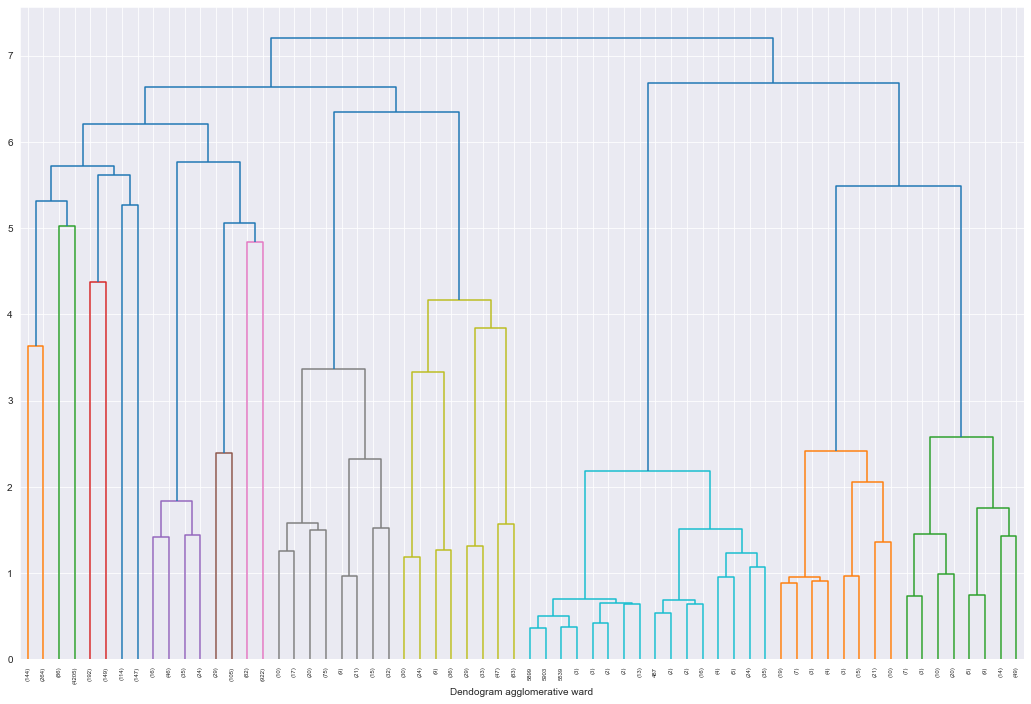

In [88]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative ward')
plt.show()

## Agglomerative (complete)

In [89]:
clst_agg_avg = AgglomerativeClustering(n_clusters=10, linkage='complete')
clst_agg_avg.fit(vec_matrix_tsvd)

AgglomerativeClustering(linkage='complete', n_clusters=10)

In [90]:
data['label'] = clst_agg_avg.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  \
0     ukraine angr

In [91]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

4    0.681559
3    0.112439
2    0.080798
0    0.030690
5    0.020505
8    0.018061
1    0.017925
6    0.013580
7    0.012765
9    0.011678
Name: label, dtype: float64

In [92]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0       atrocity  0.587729      4
1          price  0.589479      4
2          dutch  0.500159      4
3           east  0.630975      4
4            day  0.586031      4
..           ...       ...    ...
89         mixed  0.745554      7
90        double  0.666446      7
91         grace  0.699478      7
92          game  0.588335      7
93  commonwealth  0.678358      7

[1496 rows x 3 columns]

In [93]:
viz_data.to_csv('./Data/combined-agg-complete-clusters.csv', index=False)

In [94]:
visualize_clusters(viz_data)

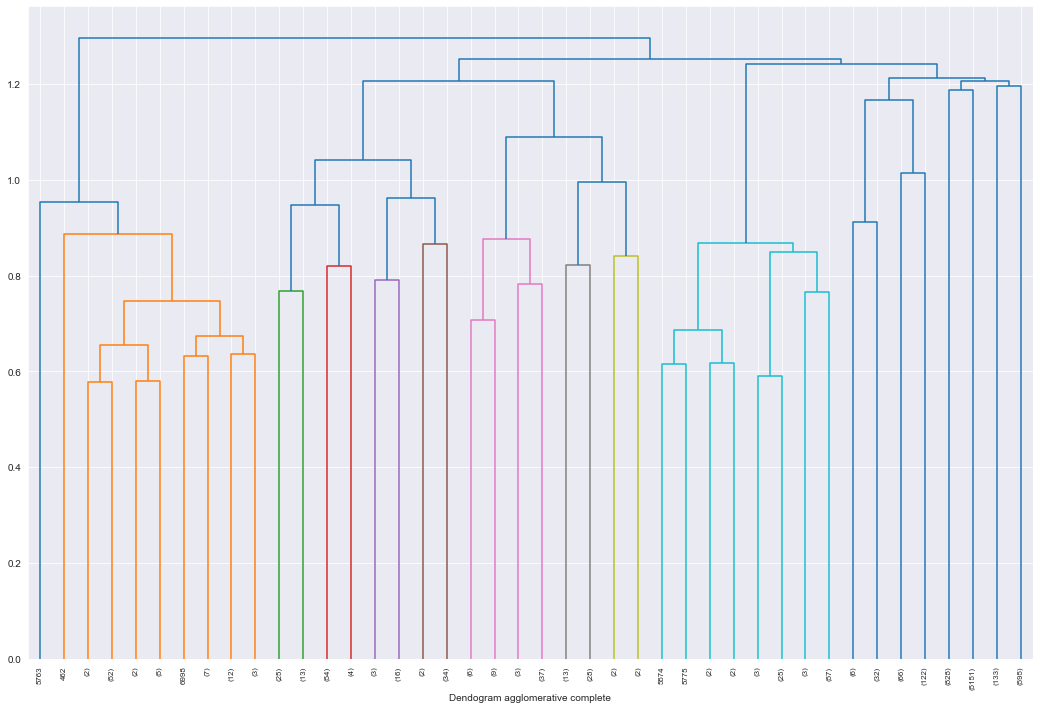

In [95]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative complete')
plt.show()

## DBSCAN

In [96]:
dbscan = DBSCAN(eps=0.5)
dbscan.fit(vec_matrix_tsvd)

DBSCAN()

In [97]:
data['label'] = dbscan.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  \
0     ukraine angr

In [98]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

 0    0.989815
-1    0.010185
Name: label, dtype: float64

In [99]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0    atrocity  0.587729      0
1        flee  0.501800      0
2        food  0.580697      0
3       arena  0.616408      0
4       price  0.589479      0
..        ...       ...    ...
70     action  0.523330     -1
71    holiday  0.534987     -1
72      royal  0.572235     -1
73  president  0.702271     -1
74        win  0.480951     -1

[275 rows x 3 columns]

In [100]:
viz_data.to_csv('./Data/combined-dbscan-clusters.csv', index=False)

In [101]:
visualize_clusters(viz_data)

## OPTICS

In [108]:
optics = OPTICS(min_samples=10)
optics.fit(vec_matrix_tsvd)

OPTICS(min_samples=10)

In [109]:
data['label'] = optics.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                               combined  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2     Ukraine war 'catastrophic for global food' One...   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360  The queue - and the expert who helped plan it ...   
7361  The cowboy and the Queen who bonded over horse...   
7362  Queen amused by an American's breach of protoc...   
7363  Queen Elizabeth II's special connection with W...   

                                       combined_cleaned  combined_polarity  \
0     ukraine angr

In [110]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

-1    0.991852
 3    0.002852
 0    0.002173
 1    0.001765
 2    0.001358
Name: label, dtype: float64

In [111]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0   atrocity  0.587729     -1
1       flee  0.501800     -1
2       food  0.580697     -1
3      arena  0.616408     -1
4      price  0.589479     -1
..       ...       ...    ...
16  abortion  0.598949      3
17       roe  0.562544      3
18      pill  0.551162      3
19  abortion  0.598949      3
20  abortion  0.598949      3

[260 rows x 3 columns]

In [112]:
viz_data.to_csv('./Data/combined-optics-clusters.csv', index=False)

In [113]:
visualize_clusters(viz_data)